
# A. Reading the Data

In [32]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt


In [2]:
# Load dataset
# Data set with 1340 rows × 21 columns

df = pd.read_csv("./nba_logreg.csv")

df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


# B. Features processing

In [3]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels

##### Total assists made, total minutes played etc do not take into account the number of games played as well. ie, it may be possible that a certain player has more minutes in one game while he has less in the other.

##### So, it's better to have metrics like minutes, rebounds, assists, steals etc seen per game.


In [4]:

df["min/game"] = df["MIN"]/df["GP"]
df["rebound/game"] = df["REB"]/df["GP"]
df["assist/game"] = df["AST"]/df["GP"]
df["steals/game"] = df["STL"]/df["GP"]
df["blocks/game"] = df["BLK"]/df["GP"]
df["turnovers/game"] = df["TOV"]/df["GP"]
df["label"] = df["TARGET_5Yrs"]
# It also helps in reducing variance in the results because the number of features decrease!!

df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,BLK,TOV,TARGET_5Yrs,min/game,rebound/game,assist/game,steals/game,blocks/game,turnovers/game,label
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,0.4,1.3,0.0,0.761111,0.113889,0.052778,0.011111,0.011111,0.036111,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,0.5,1.6,0.0,0.768571,0.068571,0.105714,0.031429,0.014286,0.045714,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,0.3,1.0,0.0,0.206757,0.029730,0.013514,0.006757,0.004054,0.013514,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,0.1,1.0,1.0,0.200000,0.032759,0.013793,0.010345,0.001724,0.017241,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,0.4,0.8,1.0,0.239583,0.052083,0.006250,0.006250,0.008333,0.016667,1.0


##### Removing unneeded columns

In [5]:
df = df.drop(columns=["GP", "MIN", "FGM", "FGA", "3P Made", "3PA", "FTM", "FTA", "OREB", "DREB", "REB", "AST", "STL", "BLK", "TOV", "TARGET_5Yrs"])
df.head()

,Name,PTS,FG%,3P%,FT%,min/game,rebound/game,assist/game,steals/game,blocks/game,turnovers/game,label
0,Brandon Ingram,7.4,34.7,25.0,69.9,0.761111,0.113889,0.052778,0.011111,0.011111,0.036111,0.0
1,Andrew Harrison,7.2,29.6,23.5,76.5,0.768571,0.068571,0.105714,0.031429,0.014286,0.045714,0.0
2,JaKarr Sampson,5.2,42.2,24.4,67.0,0.206757,0.029730,0.013514,0.006757,0.004054,0.013514,0.0
3,Malik Sealy,5.7,42.6,22.6,68.9,0.200000,0.032759,0.013793,0.010345,0.001724,0.017241,1.0
4,Matt Geiger,4.5,52.4,0.0,67.4,0.239583,0.052083,0.006250,0.006250,0.008333,0.016667,1.0


##### Rename columns

In [6]:
df = df.rename(columns={"pts": "points/game", "fg": "field_goal_%", "3p": "3_point_%", "ft": "free_throw_%"})
df.head()

,Name,PTS,FG%,3P%,FT%,min/game,rebound/game,assist/game,steals/game,blocks/game,turnovers/game,label
0,Brandon Ingram,7.4,34.7,25.0,69.9,0.761111,0.113889,0.052778,0.011111,0.011111,0.036111,0.0
1,Andrew Harrison,7.2,29.6,23.5,76.5,0.768571,0.068571,0.105714,0.031429,0.014286,0.045714,0.0
2,JaKarr Sampson,5.2,42.2,24.4,67.0,0.206757,0.029730,0.013514,0.006757,0.004054,0.013514,0.0
3,Malik Sealy,5.7,42.6,22.6,68.9,0.200000,0.032759,0.013793,0.010345,0.001724,0.017241,1.0
4,Matt Geiger,4.5,52.4,0.0,67.4,0.239583,0.052083,0.006250,0.006250,0.008333,0.016667,1.0


##### Shuffling Rows

In [7]:
shuffled_rows = np.random.permutation(df.index)

df = df.iloc[shuffled_rows]

df.head()

df.isnull().sum()

Name               0
PTS                0
FG%                0
3P%               11
FT%                0
min/game           0
rebound/game       0
assist/game        0
steals/game        0
blocks/game        0
turnovers/game     0
label              0
dtype: int64

In [8]:
df.dropna(subset=["3P%"], inplace=True)

df.corr()["PTS"]

PTS               1.000000
FG%               0.261587
3P%               0.151072
FT%               0.254404
min/game          0.525724
rebound/game      0.416978
assist/game       0.381396
steals/game       0.399350
blocks/game       0.246219
turnovers/game    0.581167
label             0.314632
Name: PTS, dtype: float64

# C. Models Training

In [9]:

def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=3
    
    print(" confusion matrix : ")
    print(confusion_mat)
    print("recall : ", recall)
    return recall

In [10]:
recalls = []
cols = df.columns.drop(["Name", "label"])
df_vals = df.drop(['label','Name'],axis=1).values
labels = df['label'].values # labels
# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

# normalize dataset
X = MinMaxScaler().fit_transform(df_vals)
cols

Index(['PTS', 'FG%', '3P%', 'FT%', 'min/game', 'rebound/game', 'assist/game',
       'steals/game', 'blocks/game', 'turnovers/game'],
      dtype='object')

### 1.Training using LogisticRegression

In [11]:
lregression = LogisticRegression(C=0.1, 
                           max_iter=100, 
                           fit_intercept=True, 
                           n_jobs=3, 
                           solver='liblinear')

In [12]:
# Scoring with Logistic regression classifier
lr_recall = score_classifier(X, lregression, labels)
recalls.append(lr_recall)

 confusion matrix : 
[[  9. 494.]
 [  1. 825.]]
recall :  0.9988425925925926


/home/nora/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/nora/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/nora/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



### 2.Training using Random Forest

In [13]:
randomForestC = RandomForestClassifier(max_depth=2, random_state=0)

In [14]:
# Scoring with Random Forest classifier
rd_recall = score_classifier(X, randomForestC, labels)
recalls.append(rd_recall)

 confusion matrix : 
[[141. 362.]
 [ 87. 739.]]
recall :  0.8949767126653919


/home/nora/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 3.Training using Support Vector

In [15]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [16]:
# Scoring with Support Vector classifier
svm_recall = score_classifier(X, clf_svm, labels)
recalls.append(svm_recall)

 confusion matrix : 
[[197. 306.]
 [116. 710.]]
recall :  0.8607224929158891


### 4.Training using Gradient Boosting

In [17]:
clf_boosting = GradientBoostingClassifier(random_state=0)

In [18]:
# Scoring with Gradient Boosting classifier
boosting_recall = score_classifier(X, clf_boosting, labels)
recalls.append(boosting_recall)

 confusion matrix : 
[[227. 276.]
 [150. 676.]]
recall :  0.8182703346618441


## Plot results

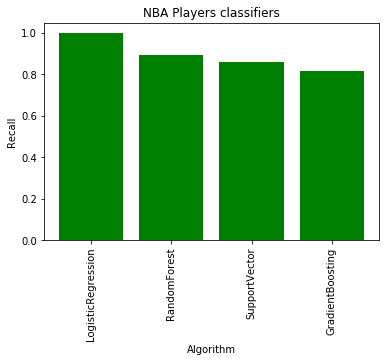

In [31]:
axis = [1, 2, 3, 4]
x_labels = ["LogisticRegression","RandomForest","SupportVector","GradientBoosting"]
plt.figure()

plt.bar(axis, recalls, color='green', align='center')
plt.title('NBA Players classifiers')
plt.xticks(axis, x_labels, rotation='vertical')
plt.xlabel('Algorithm')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Analyse

#### Saving logistic regression model

In [20]:
# Save the model in the current working directory
joblib.dump(lregression, 'modelNBA.pkl')


['modelNBA.pkl']